**Problem Statement**

CarIns is a startup that provides insurance for cars. It is one of the best car insurance brands known for the highest claim settlement ratio. It was launched back in Oct 2020 and acquired its initial policyholders by providing a hassle-free claim process, instant policy issuance, and claim settlements at minimum coverages.

As it's a fast growing startup, the company would like to optimize the cost of the insurance by identifying the policyholders who are more likely to claim in the next 6 months.

Now the company would like to use Data Science to identify the policyholders whose chances of filing a claim are high in the next 6 months. The company challenges the Data Science community to build a high-performance algorithm to predict if the policyholder will file a claim in the next 6 months or not based on the set of car and policy features.

# Importing Libraries

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xg
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score,plot_confusion_matrix,precision_recall_curve,plot_precision_recall_curve
from imblearn.over_sampling import SMOTE    
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler                    # Importing standard scaler to perform standardization
from sklearn.feature_selection import SelectFromModel               # To select features from model using Yellow bricks
from yellowbrick.model_selection import FeatureImportances          # To select important features out of the model

pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth",None)
pd.set_option('mode.chained_assignment', None) 
pd.set_option("display.float_format", lambda x : '%.5f' %x)
import warnings
warnings.filterwarnings('ignore')

# Data Acquisition

In [ ]:
train = pd.read_csv('/content/AV_train.csv')
print(train.shape)
train.head(1)

(58592, 44)


,policy_id,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,max_torque,max_power,engine_type,airbags,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,is_parking_camera,rear_brakes_type,displacement,cylinder,transmission_type,gear_box,steering_type,turning_radius,length,width,height,gross_weight,is_front_fog_lights,is_rear_window_wiper,is_rear_window_washer,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim
0,ID00001,0.51587,0.05000,0.64423,C1,4990,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.60000,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,0


In [ ]:
test = pd.read_csv('/content/AV_test.csv')
print(test.shape)
test.head(1) 


(39063, 43)


,policy_id,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,max_torque,max_power,engine_type,airbags,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,is_parking_camera,rear_brakes_type,displacement,cylinder,transmission_type,gear_box,steering_type,turning_radius,length,width,height,gross_weight,is_front_fog_lights,is_rear_window_wiper,is_rear_window_washer,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating
0,ID58593,0.34173,0.00000,0.58654,C3,4076,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.60000,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0


In [ ]:
sample = pd.read_csv('/content/sample_submission_KvRh9Sx.csv')
sample.head(1)

,policy_id,is_claim
0,ID58593,1


# Data Description & Info

In [ ]:
train.describe()

,policy_tenure,age_of_car,age_of_policyholder,population_density,make,airbags,displacement,cylinder,gear_box,turning_radius,length,width,height,gross_weight,ncap_rating,is_claim
count,58592.00000,58592.00000,58592.00000,58592.00000,58592.00000,58592.00000,58592.00000,58592.00000,58592.00000,58592.00000,58592.00000,58592.00000,58592.00000,58592.00000,58592.00000,58592.00000
mean,0.61125,0.06942,0.46942,18826.85867,1.76372,3.13707,1162.35585,3.62696,5.24544,4.85289,3850.47689,1672.23367,1553.33537,1385.27681,1.75995,0.06397
std,0.41416,0.05672,0.12289,17660.17479,1.13699,1.83264,266.30479,0.48362,0.43035,0.22806,311.45712,112.08913,79.62227,212.42309,1.38958,0.24470
min,0.00274,0.00000,0.28846,290.00000,1.00000,1.00000,796.00000,3.00000,5.00000,4.50000,3445.00000,1475.00000,1475.00000,1051.00000,0.00000,0.00000
25%,0.21025,0.02000,0.36538,6112.00000,1.00000,2.00000,796.00000,3.00000,5.00000,4.60000,3445.00000,1515.00000,1475.00000,1185.00000,0.00000,0.00000
50%,0.57379,0.06000,0.45192,8794.00000,1.00000,2.00000,1197.00000,4.00000,5.00000,4.80000,3845.00000,1735.00000,1530.00000,1335.00000,2.00000,0.00000
75%,1.03910,0.11000,0.54808,27003.00000,3.00000,6.00000,1493.00000,4.00000,5.00000,5.00000,3995.00000,1755.00000,1635.00000,1510.00000,3.00000,0.00000
max,1.39664,1.00000,1.00000,73430.00000,5.00000,6.00000,1498.00000,4.00000,6.00000,5.20000,4300.00000,1811.00000,1825.00000,1720.00000,5.00000,1.00000


In [ ]:
train.skew()

policy_tenure          0.05359
age_of_car             1.09408
age_of_policyholder    0.64005
population_density     1.67418
make                   1.19746
airbags                0.90595
displacement          -0.10532
cylinder              -0.52507
gear_box               1.18305
turning_radius         0.42098
length                 0.14580
width                 -0.48839
height                 1.03550
gross_weight           0.54695
ncap_rating            0.08515
is_claim               3.56397
dtype: float64

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58592 entries, 0 to 58591
Data columns (total 44 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   policy_id                         58592 non-null  object 
 1   policy_tenure                     58592 non-null  float64
 2   age_of_car                        58592 non-null  float64
 3   age_of_policyholder               58592 non-null  float64
 4   area_cluster                      58592 non-null  object 
 5   population_density                58592 non-null  int64  
 6   make                              58592 non-null  int64  
 7   segment                           58592 non-null  object 
 8   model                             58592 non-null  object 
 9   fuel_type                         58592 non-null  object 
 10  max_torque                        58592 non-null  object 
 11  max_power                         58592 non-null  object 
 12  engi

In [ ]:
train.isnull().sum()

policy_id                           0
policy_tenure                       0
age_of_car                          0
age_of_policyholder                 0
area_cluster                        0
population_density                  0
make                                0
segment                             0
model                               0
fuel_type                           0
max_torque                          0
max_power                           0
engine_type                         0
airbags                             0
is_esc                              0
is_adjustable_steering              0
is_tpms                             0
is_parking_sensors                  0
is_parking_camera                   0
rear_brakes_type                    0
displacement                        0
cylinder                            0
transmission_type                   0
gear_box                            0
steering_type                       0
turning_radius                      0
length      

In [ ]:
test.isnull().sum()

policy_id                           0
policy_tenure                       0
age_of_car                          0
age_of_policyholder                 0
area_cluster                        0
population_density                  0
make                                0
segment                             0
model                               0
fuel_type                           0
max_torque                          0
max_power                           0
engine_type                         0
airbags                             0
is_esc                              0
is_adjustable_steering              0
is_tpms                             0
is_parking_sensors                  0
is_parking_camera                   0
rear_brakes_type                    0
displacement                        0
cylinder                            0
transmission_type                   0
gear_box                            0
steering_type                       0
turning_radius                      0
length      

# Data Preparation

In [ ]:
df_train = train.copy()
df_test = test.copy()

In [ ]:
df_train.drop(['policy_id'],axis = 1 , inplace = True)
df_test.drop('policy_id' , axis = 1 , inplace = True)


In [ ]:
#Intialize empty list for categorical features and their length
cat_features = []
label_len = []

# Identify categorical features
for i in df_train.columns:
  if (df_train[i].dtype == object):
    cat_features.append(i)

# Identify labels length per leature
for i in cat_features:
  label_len.append(len(df_train[i].unique()))

# Display total categorical features
print('Total Categorical Features:', len(cat_features))

# Create and show categorical feature frame
cat_frame = pd.DataFrame(data = {'Length': label_len}, index=cat_features)
cat_frame

Total Categorical Features: 27


,Length
area_cluster,22
segment,6
model,11
fuel_type,3
max_torque,9
max_power,9
engine_type,11
is_esc,2
is_adjustable_steering,2
is_tpms,2


In [ ]:
df_train.head(1)

,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,max_torque,max_power,engine_type,airbags,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,is_parking_camera,rear_brakes_type,displacement,cylinder,transmission_type,gear_box,steering_type,turning_radius,length,width,height,gross_weight,is_front_fog_lights,is_rear_window_wiper,is_rear_window_washer,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim
0,0.51587,0.05000,0.64423,C1,4990,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.60000,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,0


**Replace Bool columns with 0 or 1**

In [ ]:
bool_columns= ['is_esc','is_adjustable_steering','is_tpms','is_parking_sensors','is_parking_camera',
               'is_rear_window_wiper','is_rear_window_washer','is_rear_window_defogger',
               'is_brake_assist','is_power_door_locks','is_central_locking','is_power_steering',
               'is_driver_seat_height_adjustable','is_day_night_rear_view_mirror','is_ecw','is_speed_alert','is_front_fog_lights']
def dataprepare(df):
    bool_replace = {'Yes' : 1 , 'No' : 0}
    df[bool_columns] =df[bool_columns].replace(bool_replace)



**Encoding Ordinal Columns**

In [ ]:
ordinal_col = ['max_power' , 'max_torque' , 'transmission_type','steering_type']
def ordinal(df):
  df['transmission_type'] = df['transmission_type'].replace({'Manual' : 1 , 'Automatic' : 2})
  df['steering_type'] = df['steering_type'].replace({'Manual' : 1 , 'Power' : 2 , 'Electric' : 3})
  df[['max_power_bph','max_power_rpm']] = df['max_power'].apply( lambda x : pd.Series(str(x).split('@')))
  df[['max_torque_Nm','max_torque_rpm']] = df['max_torque'].apply( lambda x : pd.Series(str(x).split('@')))
  df.drop(['max_power','max_torque'], axis = 1 , inplace = True)
  df['max_power_bph']= df['max_power_bph'].str[:-3].astype(float)
  df['max_power_rpm'] = df['max_power_rpm'].str[:-3].astype(int)
  df['max_torque_Nm'] = df['max_torque_Nm'].str[:-2].astype(float)
  df['max_torque_rpm'] = df['max_torque_rpm'].str[:-3].astype(int)

**Model Evaluation**

In [ ]:
def model_eval(actual , predicted):
  acc_score = accuracy_score(actual , predicted)
  f1 = f1_score(actual , predicted)
  con_mat = confusion_matrix(actual , predicted)
  clas_report = classification_report(actual , predicted)
  print(" The accuracy of the model : " , acc_score)
  print('---------------------------------------------------------')
  print(" The F1 score of the model : " , f1)
  print('---------------------------------------------------------')
  print(con_mat)
  print('---------------------------------------------------------')
  print(clas_report)
   

# Data Post processing 

In [ ]:
dataprepare(df_train)

In [ ]:
dataprepare(df_test)

In [ ]:
ordinal(df_train)
ordinal(df_test)

In [ ]:
dummy_columns = ['area_cluster','segment','model','fuel_type','engine_type','rear_brakes_type']
df_train = pd.concat([df_train,pd.get_dummies(df_train[dummy_columns])], axis = 1)
df_train.drop(dummy_columns,axis = 1, inplace = True)


In [ ]:
df_train.head(1)

,policy_tenure,age_of_car,age_of_policyholder,population_density,make,airbags,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,is_parking_camera,displacement,cylinder,transmission_type,gear_box,steering_type,turning_radius,length,width,height,gross_weight,is_front_fog_lights,is_rear_window_wiper,is_rear_window_washer,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim,max_power_bph,max_power_rpm,max_torque_Nm,max_torque_rpm,area_cluster_C1,area_cluster_C10,area_cluster_C11,area_cluster_C12,area_cluster_C13,area_cluster_C14,area_cluster_C15,area_cluster_C16,area_cluster_C17,area_cluster_C18,area_cluster_C19,area_cluster_C2,area_cluster_C20,area_cluster_C21,area_cluster_C22,area_cluster_C3,area_cluster_C4,area_cluster_C5,area_cluster_C6,area_cluster_C7,area_cluster_C8,area_cluster_C9,segment_A,segment_B1,segment_B2,segment_C1,segment_C2,segment_Utility,model_M1,model_M10,model_M11,model_M2,model_M3,model_M4,model_M5,model_M6,model_M7,model_M8,model_M9,fuel_type_CNG,fuel_type_Diesel,fuel_type_Petrol,engine_type_1.0 SCe,engine_type_1.2 L K Series Engine,engine_type_1.2 L K12N Dualjet,engine_type_1.5 L U2 CRDi,engine_type_1.5 Turbocharged Revotorq,engine_type_1.5 Turbocharged Revotron,engine_type_F8D Petrol Engine,engine_type_G12B,engine_type_K Series Dual jet,engine_type_K10C,engine_type_i-DTEC,rear_brakes_type_Disc,rear_brakes_type_Drum
0,0.51587,0.05000,0.64423,4990,1,2,0,0,0,1,0,796,3,1,5,2,4.60000,3445,1515,1475,1185,0,0,0,0,0,0,0,1,0,0,0,1,0,0,40.36000,6000,60.00000,3500,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1


In [ ]:
df_test = pd.concat([df_test,pd.get_dummies(df_test[dummy_columns])], axis = 1)
df_test.drop(dummy_columns,axis = 1, inplace = True)
df_test.head(1)

,policy_tenure,age_of_car,age_of_policyholder,population_density,make,airbags,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,is_parking_camera,displacement,cylinder,transmission_type,gear_box,steering_type,turning_radius,length,width,height,gross_weight,is_front_fog_lights,is_rear_window_wiper,is_rear_window_washer,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,max_power_bph,max_power_rpm,max_torque_Nm,max_torque_rpm,area_cluster_C1,area_cluster_C10,area_cluster_C11,area_cluster_C12,area_cluster_C13,area_cluster_C14,area_cluster_C15,area_cluster_C16,area_cluster_C17,area_cluster_C18,area_cluster_C19,area_cluster_C2,area_cluster_C20,area_cluster_C21,area_cluster_C22,area_cluster_C3,area_cluster_C4,area_cluster_C5,area_cluster_C6,area_cluster_C7,area_cluster_C8,area_cluster_C9,segment_A,segment_B1,segment_B2,segment_C1,segment_C2,segment_Utility,model_M1,model_M10,model_M11,model_M2,model_M3,model_M4,model_M5,model_M6,model_M7,model_M8,model_M9,fuel_type_CNG,fuel_type_Diesel,fuel_type_Petrol,engine_type_1.0 SCe,engine_type_1.2 L K Series Engine,engine_type_1.2 L K12N Dualjet,engine_type_1.5 L U2 CRDi,engine_type_1.5 Turbocharged Revotorq,engine_type_1.5 Turbocharged Revotron,engine_type_F8D Petrol Engine,engine_type_G12B,engine_type_K Series Dual jet,engine_type_K10C,engine_type_i-DTEC,rear_brakes_type_Disc,rear_brakes_type_Drum
0,0.34173,0.00000,0.58654,4076,1,2,0,0,0,1,0,796,3,1,5,2,4.60000,3445,1515,1475,1185,0,0,0,0,0,0,0,1,0,0,0,1,0,40.36000,6000,60.00000,3500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1


**Scaling & Feature selection**

Now we will perform standardization and feed it to the Random Forest.

Random Forest will then identify important features for our model using threshold.

This threshold is used over the information gain which results in reduction in impurity.

And finally we will split our data for the model development.

In [ ]:
# Saving all feature names to a list in a variable
dataColumns = df_train.columns.to_list()

# Removing Class feature as it is our target
dataColumns.remove('is_claim')

encoder = StandardScaler()

for i in dataColumns:
   df_train[i] = encoder.fit_transform(df_train[[i]])

print('Success!')

Success!


In [ ]:
df_train.head(2)

,policy_tenure,age_of_car,age_of_policyholder,population_density,make,airbags,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,is_parking_camera,displacement,cylinder,transmission_type,gear_box,steering_type,turning_radius,length,width,height,gross_weight,is_front_fog_lights,is_rear_window_wiper,is_rear_window_washer,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim,max_power_bph,max_power_rpm,max_torque_Nm,max_torque_rpm,area_cluster_C1,area_cluster_C10,area_cluster_C11,area_cluster_C12,area_cluster_C13,area_cluster_C14,area_cluster_C15,area_cluster_C16,area_cluster_C17,area_cluster_C18,area_cluster_C19,area_cluster_C2,area_cluster_C20,area_cluster_C21,area_cluster_C22,area_cluster_C3,area_cluster_C4,area_cluster_C5,area_cluster_C6,area_cluster_C7,area_cluster_C8,area_cluster_C9,segment_A,segment_B1,segment_B2,segment_C1,segment_C2,segment_Utility,model_M1,model_M10,model_M11,model_M2,model_M3,model_M4,model_M5,model_M6,model_M7,model_M8,model_M9,fuel_type_CNG,fuel_type_Diesel,fuel_type_Petrol,engine_type_1.0 SCe,engine_type_1.2 L K Series Engine,engine_type_1.2 L K12N Dualjet,engine_type_1.5 L U2 CRDi,engine_type_1.5 Turbocharged Revotorq,engine_type_1.5 Turbocharged Revotron,engine_type_F8D Petrol Engine,engine_type_G12B,engine_type_K Series Dual jet,engine_type_K10C,engine_type_i-DTEC,rear_brakes_type_Disc,rear_brakes_type_Drum
0,-0.23028,-0.34245,1.42256,-0.78351,-0.67171,-0.62046,-0.67664,-1.24104,-0.56079,0.20545,-0.80066,-1.37571,-1.29642,-0.73115,-0.57033,-0.73324,-1.10889,-1.30188,-1.40277,-0.98385,-0.94283,-1.17286,-0.63821,-0.63821,-0.73401,-1.10369,-1.62062,-1.62062,0.14515,-1.18789,-0.78339,-1.62062,0.07896,-1.26655,0,-1.39416,0.75574,-1.01784,-0.04570,6.23801,-0.23856,-0.14534,-0.16696,-0.24909,-0.25812,-0.11547,-0.08301,-0.09202,-0.06440,-0.12852,-0.37850,-0.04317,-0.08069,-0.05954,-0.34092,-0.10714,-0.36772,-0.12419,-0.19597,-0.55122,-0.22124,1.54360,-0.27692,-0.67431,-0.25423,-0.56079,-0.14515,1.70872,-0.14515,-0.07896,-0.13704,-0.20545,-0.56079,-0.16745,-0.55443,-0.22984,-0.27692,-0.19347,1.37188,-0.65871,-0.73448,-0.20545,-0.22984,-0.13704,-0.56079,-0.16745,-0.07896,1.70872,-0.14515,-0.55443,-0.27692,-0.19347,-0.56079,0.56079
1,0.14819,-0.87136,-0.76836,0.46297,-0.67171,-0.62046,-0.67664,-1.24104,-0.56079,0.20545,-0.80066,-1.37571,-1.29642,-0.73115,-0.57033,-0.73324,-1.10889,-1.30188,-1.40277,-0.98385,-0.94283,-1.17286,-0.63821,-0.63821,-0.73401,-1.10369,-1.62062,-1.62062,0.14515,-1.18789,-0.78339,-1.62062,0.07896,-1.26655,0,-1.39416,0.75574,-1.01784,-0.04570,-0.16031,-0.23856,-0.14534,-0.16696,-0.24909,-0.25812,-0.11547,-0.08301,-0.09202,-0.06440,-0.12852,2.64204,-0.04317,-0.08069,-0.05954,-0.34092,-0.10714,-0.36772,-0.12419,-0.19597,-0.55122,-0.22124,1.54360,-0.27692,-0.67431,-0.25423,-0.56079,-0.14515,1.70872,-0.14515,-0.07896,-0.13704,-0.20545,-0.56079,-0.16745,-0.55443,-0.22984,-0.27692,-0.19347,1.37188,-0.65871,-0.73448,-0.20545,-0.22984,-0.13704,-0.56079,-0.16745,-0.07896,1.70872,-0.14515,-0.55443,-0.27692,-0.19347,-0.56079,0.56079


# Model Development & Evaluation 

In [ ]:
x = df_train.drop('is_claim' , axis =1 )
y = df_train['is_claim']

In [ ]:
x_train,x_val,y_train,y_val = train_test_split(x , y , test_size = 0.2 , random_state = 125 , stratify = y )

In [ ]:
# x_train.shape

In [ ]:
# selector = SelectFromModel(RandomForestClassifier(n_estimators = 100, random_state = 42, n_jobs = -1))
# selector.fit(x, y)

# # Extracting list of important features
# selected_feat = x.columns[(selector.get_support())].tolist()

# print('Total Features Selected are', len(selected_feat))

# # Estimated by taking mean(default) of feature importance
# print('Threshold set by Model:', np.round(selector.threshold_, decimals = 2))
# print('Features:', selected_feat)

In [ ]:
# X = df_train[selected_feat]
# y = df_train['is_claim']

In [ ]:
# X_train, X_test, y_train,y_test = train_test_split(X,y,test_size = 0.2 , random_state = 125 , stratify = y)

**Logistic Regression**

In [ ]:
logreg = LogisticRegression()
logreg.fit(x_train,y_train)

LogisticRegression()

In [ ]:
y_pred_train = logreg.predict(x_train)

In [ ]:
y_pred_test = logreg.predict(x_val)

In [ ]:
model_eval(y_train,y_pred_train)

 The accuracy of the model :  0.9360399377040087
---------------------------------------------------------
 The F1 score of the model :  0.0
---------------------------------------------------------
[[43875     0]
 [ 2998     0]]
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     43875
           1       0.00      0.00      0.00      2998

    accuracy                           0.94     46873
   macro avg       0.47      0.50      0.48     46873
weighted avg       0.88      0.94      0.91     46873



Observation:

Train Data:

Model predicted 43875 instances correctly for negative class while 0 instances were predicted for positive class.

Model identified 2998 instance negative but in actual they were positive.

Model identified 0 instances positive but in actual they were negative.

We can observe that model is performing pretty well on negative class i.e. non-claim but not good on positive class.

The precision score is 0 in both training data as well as on testing data for positive class .

<Figure size 1080x504 with 0 Axes>

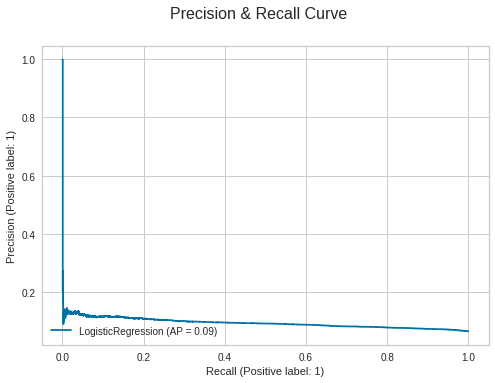

In [ ]:
fig= plt.figure( figsize = (15, 7))

plot_precision_recall_curve(estimator = logreg, X = x_train, y= y_train)
plt.suptitle('Precision & Recall Curve', size = 16)
plt.show()

In [ ]:
print('Training Data Shape:', x_train.shape, y_train.shape)
print('Testing Data Shape:', x_val.shape, y_val.shape)

Training Data Shape: (46873, 93) (46873,)
Testing Data Shape: (11719, 93) (11719,)


**Oversampling imbalance Data using SMOTE**

In [ ]:
from collections import Counter
counter = Counter(y_train)
print(counter)

Counter({0: 43875, 1: 2998})


In [ ]:

oversample = SMOTE(random_state = 42)
X1, y1 = oversample.fit_resample(x, y)

X_new = pd.DataFrame(data = X1, columns = x.columns)

X_train, X_test, y_train, y_test = train_test_split(X_new, y1, test_size = 0.2, random_state = 42, stratify = y1)

In [ ]:
pd.Series(y_train).value_counts()

0    43875
1    43875
Name: is_claim, dtype: int64

In [ ]:
print('Training Data Shape after oversampling :', X_train.shape, y_train.shape)
print('Testing Data Shape after oversampling:', X_test.shape, y_test.shape)

Training Data Shape after oversampling : (87750, 93) (87750,)
Testing Data Shape after oversampling: (21938, 93) (21938,)


**Logistic Regression after Oversampling**

In [ ]:
reg = LogisticRegression()
reg.fit(X_train,y_train)

LogisticRegression()

In [ ]:
y_reg_pred_train = reg.predict(X_train)
y_reg_pred_test = reg.predict(X_test)

In [ ]:
model_eval(y_train,y_reg_pred_train)

 The accuracy of the model :  0.5891168091168091
---------------------------------------------------------
 The F1 score of the model :  0.5965422704638282
---------------------------------------------------------
[[25040 18835]
 [17220 26655]]
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.59      0.57      0.58     43875
           1       0.59      0.61      0.60     43875

    accuracy                           0.59     87750
   macro avg       0.59      0.59      0.59     87750
weighted avg       0.59      0.59      0.59     87750



**RandomForest After Oversampling**

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_rf_pred_train = rf.predict(X_train)
y_rf_pred_test = rf.predict(X_test)

In [ ]:
model_eval(y_train,y_rf_pred_train)

 The accuracy of the model :  0.999988603988604
---------------------------------------------------------
 The F1 score of the model :  0.9999886041184716
---------------------------------------------------------
[[43874     1]
 [    0 43875]]
---------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     43875
           1       1.00      1.00      1.00     43875

    accuracy                           1.00     87750
   macro avg       1.00      1.00      1.00     87750
weighted avg       1.00      1.00      1.00     87750



In [ ]:
model_eval(y_test,y_rf_pred_test)

 The accuracy of the model :  0.9019965356914942
---------------------------------------------------------
 The F1 score of the model :  0.9030833032816444
---------------------------------------------------------
[[ 9771  1198]
 [  952 10017]]
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.89      0.90     10969
           1       0.89      0.91      0.90     10969

    accuracy                           0.90     21938
   macro avg       0.90      0.90      0.90     21938
weighted avg       0.90      0.90      0.90     21938



In [ ]:
f1=f1_score(y_test,y_rf_pred_test)
f1

0.9030833032816444

**CatBoost**

In [ ]:
from catboost import CatBoostClassifier
catboost_base = CatBoostClassifier(verbose = False , random_state = 0,scale_pos_weight  = 10)
catboost_base.fit(X_train,y_train, eval_set = (X_test,y_test))

In [ ]:
y_cat_pred_train = catboost_base.predict(X_train)
y_cat_pred_test = catboost_base.predict(X_test)

In [ ]:
model_eval(y_train,y_cat_pred_train)

 The accuracy of the model :  0.834017094017094
---------------------------------------------------------
 The F1 score of the model :  0.8566705045316328
---------------------------------------------------------
[[29658 14217]
 [  348 43527]]
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.68      0.80     43875
           1       0.75      0.99      0.86     43875

    accuracy                           0.83     87750
   macro avg       0.87      0.83      0.83     87750
weighted avg       0.87      0.83      0.83     87750



In [ ]:
model_eval(y_test,y_cat_pred_test)

 The accuracy of the model :  0.811104020421187
---------------------------------------------------------
 The F1 score of the model :  0.8375029409458081
---------------------------------------------------------
[[ 7115  3854]
 [  290 10679]]
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.65      0.77     10969
           1       0.73      0.97      0.84     10969

    accuracy                           0.81     21938
   macro avg       0.85      0.81      0.81     21938
weighted avg       0.85      0.81      0.81     21938



<Figure size 1080x504 with 0 Axes>

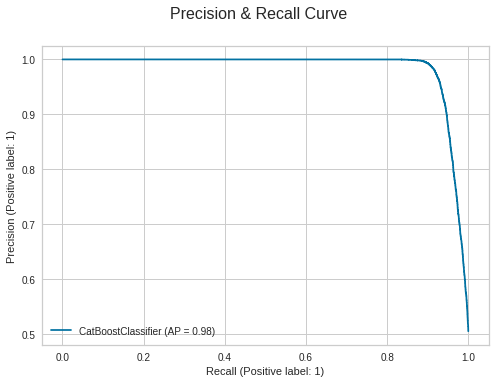

In [ ]:
fig= plt.figure( figsize = (15, 7))

plot_precision_recall_curve(estimator = catboost_base, X = X_test, y= y_test)
plt.suptitle('Precision & Recall Curve', size = 16)
plt.show()

In [ ]:
pred_test = catboost_base.predict(df_test)

In [ ]:
test['is_claim'] = pred_test
test['policy_id'] = sample['policy_id']

sample_catboost= test[['policy_id','is_claim']]

sample_catboost.to_csv("sample_catboost.csv", index=False)

sample_catboost.head()

,policy_id,is_claim
0,ID58593,1
1,ID58594,1
2,ID58595,1
3,ID58596,1
4,ID58597,1
